In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_excel("BS_EN_Dataset.xlsx")

In [480]:
#Functions to expand rows
#yield or tensile is a range
def expand_row(row, feature, k): #row = df.iloc[[i]], i = 0:139
    feat_range = row.reset_index()[feature][0].split("-")
    feat_range = list(np.linspace(int(feat_range[0]), int(feat_range[1]), k))
    feat_range = [int(i) for i in feat_range]
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    row[feature] = feat_range
    return row

#yield and tensile are ranges
def expand_row_2(row, k):
    yield_range = row.reset_index()["Yield Strength"][0].split("-")
    mean_yield = int((int(yield_range[0]) + int(yield_range[1])) / 2)
    row = row.reset_index()
    row.at[0, "Yield Strength"] = mean_yield
    return expand_row(row, "Tensile Strength", k)

#yield and tensile are not ranges
def expand_row_3(row, k):
    feat_range = list(np.linspace(row["Tensile Strength"] - 4, row["Tensile Strength"] + 5, k))
    feat_range = [int(i) for i in feat_range]
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    row["Tensile Strength"] = feat_range
    return row

In [505]:
#Create expanded dataset
def expand_df(df, k):
    df2 = pd.DataFrame(columns=list(df.columns))
    for i in range(len(df)):
        row = df.iloc[[i]]
        if type(row.reset_index()["Tensile Strength"][0]) == str and type(row.reset_index()["Yield Strength"][0]) != str:
            expanded_row = expand_row(row, "Tensile Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row(row, "Yield Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) == str:
            expanded_row = expand_row_2(row, k)
        elif type(row.reset_index()["Yield Strength"][0]) != str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row_3(row, k)
        df2 = pd.concat([df2, expanded_row], ignore_index=True)
    return df2.drop("index", axis = 1)

df2 = expand_df(df, 3)

In [425]:
#Prepare data
from sklearn.model_selection import train_test_split

# change data types to integers
df2.Elongation = df2.Elongation.astype("int")
df2["Yield Strength"] = df2["Yield Strength"].astype("int")
df2["Tensile Strength"] = df2["Tensile Strength"].astype("int")

#normalize data
def normalize_data(df):
    df2_min_max_scaled = df2.copy()
    for column in df2_min_max_scaled.columns[2:5]:
        df2_min_max_scaled[column] = (df2_min_max_scaled[column] - df2_min_max_scaled[column].min()) / (df2_min_max_scaled[column].max() - df2_min_max_scaled[column].min())
    x = df2_min_max_scaled[df2_min_max_scaled.columns[2:5]].values.tolist()
    return x

#split data
def split_data(elem):
    x = normalize_data(df2)
    y = df2[elem].values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
    return x_train, x_test, y_train, y_test

#normalize new datapoint
def normalize_point(point, df_slice):
    for i in range(len(df_slice.columns)):
        point[i] = (point[i] - df_slice[df_slice.columns[i]].min()) / (df_slice[df_slice.columns[i]].max() - df_slice[df_slice.columns[i]].min())
    return np.array([point])

In [488]:
# initial k-nn model
from sklearn.neighbors import KNeighborsClassifier

#train model
def run_model_KNN(n):
    scores = []
    for elem in list(df.columns)[5:]:
        x_train, x_test, y_train, y_test = split_data(elem)
        clf = KNeighborsClassifier(n_neighbors=n)
        clf.fit(x_train, y_train)
        print("Test set accuracy for "+elem+": {:.2f}".format(clf.score(x_test, y_test)))
        scores.append(clf.score(x_test, y_test))
    print("\nAverage accuracy: {:.2f}".format(sum(scores)/15))
    return scores

#test new datapoint
def test_point(point, df, n):
    norm_point = normalize_point(point, df[df.columns[2:5]])
    average_score = 0
    for elem in list(df.columns)[5:]:
        x_train, x_test, y_train, y_test = split_data(elem)
        clf = KNeighborsClassifier(n_neighbors=n)
        clf.fit(x_train, y_train)
        print("Model prediction for "+elem+": " + str(clf.predict(norm_point)))

run_model_KNN(10)

Test set accuracy for C: 0.75
Test set accuracy for Si: 0.85
Test set accuracy for Mn: 0.75
Test set accuracy for P: 0.74
Test set accuracy for S: 0.66
Test set accuracy for N: 0.83
Test set accuracy for Cu: 0.81
Test set accuracy for Cr: 0.85
Test set accuracy for Ni: 0.83
Test set accuracy for Mo: 0.84
Test set accuracy for Al: 0.83
Test set accuracy for Ti: 0.83
Test set accuracy for V: 0.81
Test set accuracy for Nb: 0.89
Test set accuracy for B: 1.00

Average accuracy: 0.82


[0.7534693877551021,
 0.8453061224489796,
 0.7493877551020408,
 0.7351020408163266,
 0.6620408163265306,
 0.8338775510204082,
 0.8057142857142857,
 0.8514285714285714,
 0.8253061224489796,
 0.8371428571428572,
 0.8253061224489796,
 0.8322448979591837,
 0.8122448979591836,
 0.8857142857142857,
 0.9979591836734694]

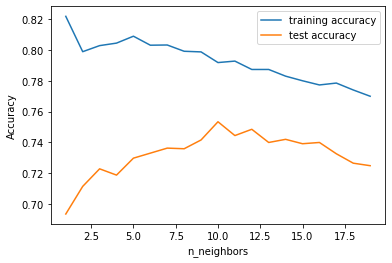

In [435]:
x_train, x_test, y_train, y_test = split_data("C")

training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 20)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

Test set accuracy for C: 0.75
Test set accuracy for Si: 0.85
Test set accuracy for Mn: 0.75
Test set accuracy for P: 0.74
Test set accuracy for S: 0.66
Test set accuracy for N: 0.83
Test set accuracy for Cu: 0.81
Test set accuracy for Cr: 0.85
Test set accuracy for Ni: 0.83
Test set accuracy for Mo: 0.84
Test set accuracy for Al: 0.83
Test set accuracy for Ti: 0.83
Test set accuracy for V: 0.81
Test set accuracy for Nb: 0.89
Test set accuracy for B: 1.00

Average accuracy: 0.82


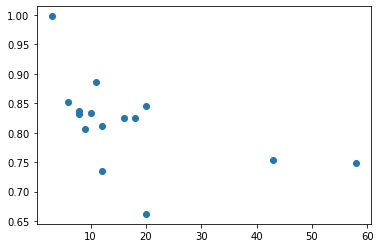

In [493]:
classes = [len(df2[elem].unique()) for elem in df2.columns[5:20]]
scores = run_model_KNN(10)
plt.scatter(classes, scores)

In [458]:
from sklearn.ensemble import RandomForestClassifier
def run_model_forest(n):
    average_score = 0
    for elem in list(df.columns)[5:]:
        x_train, x_test, y_train, y_test = split_data(elem)
        forest = RandomForestClassifier(n_estimators=n, random_state=1)
        forest.fit(x_train, y_train)
        print("Test set accuracy for "+elem+": {:.2f}".format(forest.score(x_test, y_test)))
        average_score += forest.score(x_test, y_test)
    print("\nAverage accuracy: {:.2f}".format(average_score/15))
run_model_forest(10)

Test set accuracy for C: 0.70
Test set accuracy for Si: 0.83
Test set accuracy for Mn: 0.70
Test set accuracy for P: 0.70
Test set accuracy for S: 0.62
Test set accuracy for N: 0.81
Test set accuracy for Cu: 0.77
Test set accuracy for Cr: 0.83
Test set accuracy for Ni: 0.81
Test set accuracy for Mo: 0.82
Test set accuracy for Al: 0.80
Test set accuracy for Ti: 0.80
Test set accuracy for V: 0.79
Test set accuracy for Nb: 0.88
Test set accuracy for B: 1.00

Average accuracy: 0.79


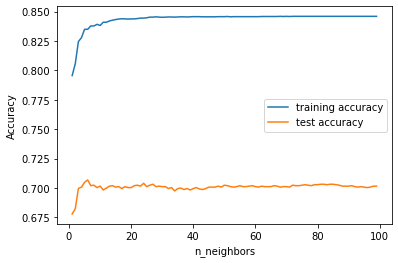

In [449]:
x_train, x_test, y_train, y_test = split_data("C")

training_accuracy = []
test_accuracy = []
n_estimators = range(1, 100)

for n in n_estimators:
    # build the model
    forest = RandomForestClassifier(n_estimators=n, random_state=2)
    forest.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy.append(forest.score(x_train, y_train))
    # record generalization accuracy
    test_accuracy.append(forest.score(x_test, y_test))
    
plt.plot(n_estimators, training_accuracy, label="training accuracy")
plt.plot(n_estimators, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()

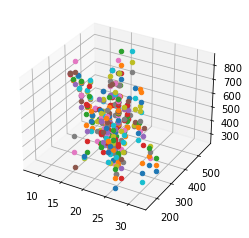

In [506]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

x_train, x_test, y_train, y_test = split_data("Cr")

fig = plt.figure()
ax = plt.axes(projection="3d")
colors = ["b", "g", "r", "c", "m", "k"]
color_match = {}
for i in range(len(list(df2["Cr"].unique()))):
    color_match[list(df2["Cr"].unique())[i]] = colors[i]
for i in range(len(df2)):
    x = df2.at[i, "Elongation"]
    y = df2.at[i, "Yield Strength"]
    z = df2.at[i, "Tensile Strength"]
    cr_class = df2.at[i, "Cr"]
    ax.scatter3D(x, y, z, color_match[cr_class]);
plt.show()
